# Lab05

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap

### Ejercicio 01

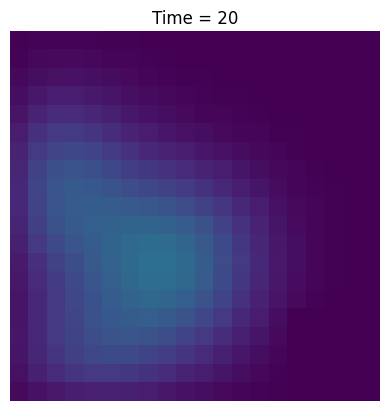

In [51]:
def initialize_grid(M, N, restricted_areas):
    """
    Initialize the grid and set restricted areas.
    
    Args:
    - M: Number of rows in the grid.
    - N: Number of columns in the grid.
    - restricted_areas: List of restricted areas, where each area is defined by
      a tuple (x_start, y_start, x_end, y_end), representing the top-left and bottom-right corners.

    Returns:
    - grid: The grid with ones (1) for allowed areas and zeros (0) for restricted areas.
    """
    grid = np.ones((M, N))
    
    # Apply each restricted area (set to 0)
    for (x_start, y_start, x_end, y_end) in restricted_areas:
        grid[x_start:x_end, y_start:y_end] = 0
    
    return grid

def generate_gaussian_spots(u0, grid, M, N, num_spots, max_radius, sigma):
    """
    Generate Gaussian-like spots on the grid, avoiding restricted areas.
    """
    # Generate Gaussian-like spots on the grid, avoiding restricted areas
    for _ in range(num_spots):
        valid_center_found = False
        
        # Ensure the center is within the valid area
        while not valid_center_found:
            x_center, y_center = np.random.randint(0, M), np.random.randint(0, N)
            if grid[x_center, y_center] == 1:  # Only proceed if it's inside the valid area
                valid_center_found = True
        
        # For each spot, set a decaying value based on the distance from the center
        for i in range(M):
            for j in range(N):
                # Calculate distance from the center
                distance = np.sqrt((i - x_center)**2 + (j - y_center)**2)
                if distance <= max_radius and grid[i, j] == 1:  # Inside the radius and valid region
                    # Use a Gaussian-like decay: higher at the center, lower at the edges
                    u0[i, j] = np.exp(-distance**2 / (2 * sigma**2))

    return u0

def diffusion_simulation(M, N, restricted_areas, T, K, u0):
    """
    Perform a diffusion simulation on the grid.
    """
    grid = initialize_grid(M, N, restricted_areas)
    u = u0.copy()  # Copy initial distribution

    # Store each step of the simulation for visualization
    frames = [u.copy()]

    # Neighborhood shifts for 8 neighbors
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

    # For each time step
    for t in range(1, T + 1):
        new_u = u.copy()  # Copy current grid state
        for i in range(M):
            for j in range(N):
                if grid[i, j] == 1:  # Only update for cells in allowed areas
                    neighbor_sum = 0

                    # Calculate the sum of neighbors
                    for dx, dy in neighbors:
                        ni, nj = i + dx, j + dy
                        if 0 <= ni < M and 0 <= nj < N and grid[ni, nj] == 1:
                            neighbor_sum += u[ni, nj]

                    # Update the cell using the diffusion equation
                    new_u[i, j] = (1 - K) * u[i, j] + (K / 8) * neighbor_sum
        
        u = new_u  # Update the state for the next time step
        frames.append(u.copy())  # Store frame for visualization
    
    return frames  # Return all frames for visualization

def visualize_diffusion(M, N, restricted_areas, T, K, u0):
    """
    Visualize the diffusion process using an animation.
    """
    # Run the simulation and get frames
    frames = diffusion_simulation(M, N, restricted_areas, T, K, u0)

    # Create a figure for plotting
    fig, ax = plt.subplots()

    # Use the 'viridis' colormap
    cmap = plt.get_cmap('viridis')

    # Update function for animation
    def update(t):
        ax.clear()
        cax = ax.imshow(frames[t], cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
        ax.set_title(f'Time = {t}')
        plt.axis('off')

    # Create animation and assign it to a variable to prevent deletion
    ani = animation.FuncAnimation(fig, update, frames=range(T+1), repeat=False)

    # Save the animation as a GIF file
    ani.save('simulation.gif', writer='pillow')

    # Show the animation
    plt.show()
    
    return ani

# Parameters
M, N = 20, 20  # Grid dimensions
restricted_areas = [(15, 15, 20, 20)]  # Define multiple restricted areas
T = 20  # Time steps
K = 0.5  # Diffusion speed parameter
u0 = np.zeros((M, N))  # Initialize the grid with zeros

# Initialize the grid with restricted areas
grid = initialize_grid(M, N, restricted_areas)

# Generate Gaussian-like spots, avoiding restricted areas, with decreasing value from the center
u0 = generate_gaussian_spots(u0, grid, M, N, num_spots=3, max_radius=5, sigma=2)

# Visualize the diffusion process and assign the animation to a variable
visualize_diffusion(M, N, restricted_areas, T, K, u0)




### Ejercicio 02